# LayoutLM with Smaller Dataset

### Downloading Libraries

In [1]:
%%capture
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
!pip install pytesseract
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 24.9 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 30.0 MB/s 
     |████████████████████████████████| 212 kB 72.9 MB/s 
     |████████████████████████████████| 115 kB 68.6 MB/s 
     |████████████████████████████████| 127 kB 71.9 MB/s 
     |████████████████████████████████| 115 kB 62.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 18.6 MB/s 
     |████████████████████████████████| 7.6 MB 51.4 MB/s 


In [2]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,839 kB/s)
debconf: unable to initi

### Importing Libraries

In [3]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

from google.colab import files
from pathlib import Path
import shutil
import zipfile

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ForSequenceClassification, AdamW

### Loading Dataset

In [4]:
!pip install kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ritvik1909/document-classification-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
document-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
local_zip = '/content/document-classification-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [6]:
dataset_path = '/content/data'
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'email': 0, 'resume': 1, 'scientific_publication': 2}

In [7]:
images = []
labels = []

for label in os.listdir(dataset_path):
    images.extend([
        f"{dataset_path}/{label}/{img_name}" for img_name in os.listdir(f"{dataset_path}/{label}")
    ])
    labels.extend([
        label for _ in range(len(os.listdir(f"{dataset_path}/{label}")))
    ])
data = pd.DataFrame({'image_path': images, 'label': labels})

train_data, valid_data = train_test_split(data, test_size=0.09, random_state=0, stratify=data.label)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print(f"{len(train_data)} training examples, {len(valid_data)} validation examples")
data.head()

150 training examples, 15 validation examples


,image_path,label
0,/content/data/email/doc_000448.png,email
1,/content/data/email/doc_000745.png,email
2,/content/data/email/doc_000464.png,email
3,/content/data/email/doc_000046.png,email
4,/content/data/email/doc_000142.png,email


### Data Preparation

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def encode_training_example(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    encoded_inputs["labels"] = [label2idx[label] for label in examples["label"]]
    
    return encoded_inputs

training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(label2idx), names=list(label2idx.keys())),
})

In [10]:
def training_dataloader_from_df(data):
    dataset = Dataset.from_pandas(data)
    
    encoded_dataset = dataset.map(
        encode_training_example, remove_columns=dataset.column_names, features=training_features, 
        batched=True, batch_size=2
    )
    encoded_dataset.set_format(type='torch', device=device)
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4, shuffle=True)
    batch = next(iter(dataloader))
    return dataloader

In [11]:
pytesseract.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' )

In [12]:
feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

train_dataloader = training_dataloader_from_df(train_data)
valid_dataloader = training_dataloader_from_df(valid_data)

  0%|          | 0/75 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

### Building the Model

In [13]:
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",  num_labels=len(label2idx)
)
model.to(device);

Downloading:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.15.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.21.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.1.conv3.norm.num_batches_t

### Training

In [14]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    #put the model in training mode
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == batch['labels']).float().sum()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])
    training_accuracy = 100 * training_correct / len(train_data)
    print("Training accuracy:", training_accuracy.item())  
        
    validation_loss = 0.0
    validation_correct = 0
    for batch in tqdm(valid_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        validation_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        validation_correct += (predictions == batch['labels']).float().sum()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])
    validation_accuracy = 100 * validation_correct / len(valid_data)
    print("Validation accuracy:", validation_accuracy.item())  

Epoch: 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 9.558946583420038
Training accuracy: 79.33333587646484


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Loss: 0.1709427572786808
Validation accuracy: 100.00000762939453
Epoch: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 2.8140604700893164
Training accuracy: 96.0


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Loss: 0.13254260395963988
Validation accuracy: 100.00000762939453
Epoch: 2


  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 1.1381092937663198
Training accuracy: 100.0


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Loss: 0.03304931800812483
Validation accuracy: 100.00000762939453


In [15]:
model.save_pretrained('saved_model/')

### Inference

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForSequenceClassification.from_pretrained("saved_model")
model.to(device);

In [18]:
query = '/content/data/email/doc_000042.png'
image = Image.open(query).convert("RGB")
encoded_inputs = processor(image, return_tensors="pt").to(device)
outputs = model(**encoded_inputs)
preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
pred_labels = {label:pred for label, pred in zip(label2idx.keys(), preds)}
pred_labels

{'email': 0.9793141484260559,
 'resume': 0.013004029169678688,
 'scientific_publication': 0.007681847084313631}

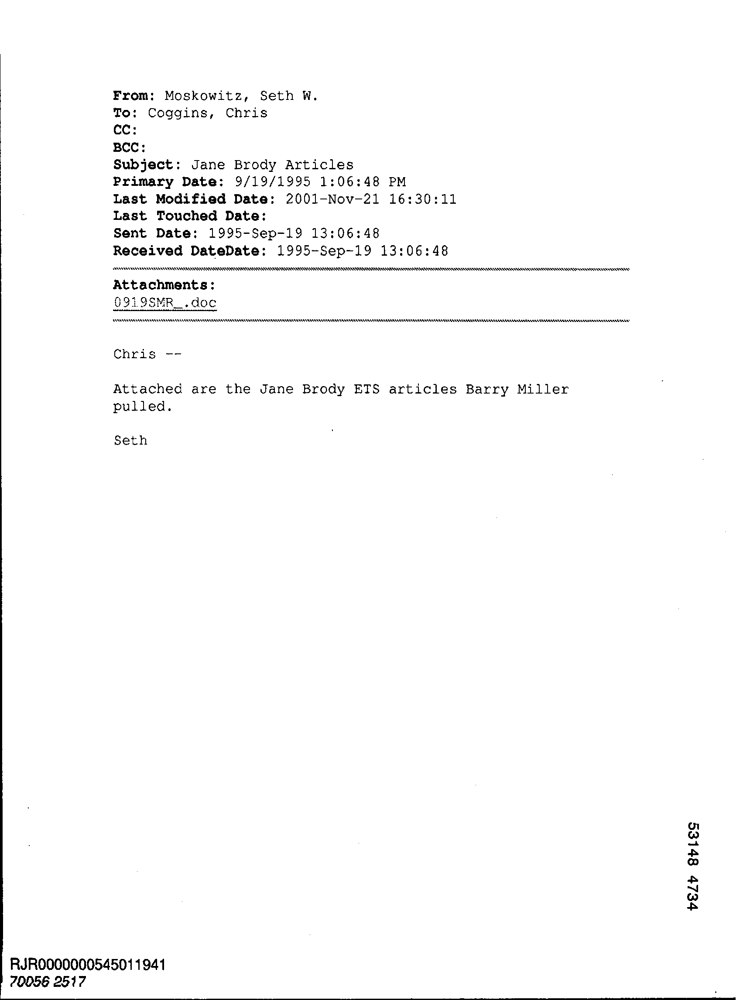

In [19]:
image

### Conclusion

LayoutLM uses a OCR to feed the text to a Transformer Network to get POS-tagged tokens which can be used to draw bounding boxes around the different kind of words in the Document revealing further patterns.

Due to incorporation of text along with spacial features, we get a much better accuracy over the validation data

Due to Hardware limitations, we used a smaller subset of data from RVL-CDIP dataset here in order to demonstrate and hence the accuracy shown here cannot be compared to the ones in part1 and part2 (submitted along with this notebook) since they use the larger 39 gb dataset